# PART 4: Neural Networks and Convolutional Neural Networks

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

#try:
    # %tensorflow_version only exists in Colab.
    #%tensorflow_version 2.x
#except Exception:
 #   pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
import pandas as pd
from numpy import mean

# to make this notebook's output stable across runs
np.random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve, auc, precision_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


LOADING DATA SET

In [2]:
# The Data is uploaded to Notebook in csv file, 
# we will store it in dataFrame (transactions) using pandas read_csv method
# in this Nootebook we will be analysing Test Data generated for credit card fraud.
# This Data is downloded from kaggle from this link: https://www.kaggle.com/ealaxi/paysim1

# Loading config files
import json
with open('config.json', 'r') as f:
    config = json.load(f)

# Loading datasets using pandas to variable 'transactions'
transactions = pd.read_csv(config['Training_Dataset'])

import helper
# remoing unnecessary attributes that wont be used in our clustering
transactions = helper.preprocessDataset(transactions)

transactions.head()


# checking data size after normalization
#transactions.describe()
#transactions.info(memory_usage = "deep")

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,3.0,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,3.0,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,4.0,181.00,181.0,0.00,0.0,0.0,1
3,1,1.0,181.00,181.0,0.00,21182.0,0.0,1
4,1,3.0,11668.14,41554.0,29885.86,0.0,0.0,0


PREPARING TEST AND TRAIN SETS

In [3]:
# get X and y
X = transactions.iloc[:, :-1]
y = transactions.isFraud

from sklearn.preprocessing import MinMaxScaler
# scale dataset to scale outliers
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

X, y = helper.balanceDataSet(X, y, 'undersample')

# split dataset to test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y, shuffle=True)


# TASK1 LINEAR CLASSIFICATION
Given dataset is binary classified data set that shows wether a particular instance (transaction) is genuine(0) or fraud(1), in the below code we will use linear regression from sklearn to see wether our dataset is linearly sepratable or not

TASK 1.1: Applying Perceptron model to train dataset and calculating accuracies

In [4]:
from sklearn.linear_model import Perceptron

perceptron = Perceptron(max_iter=1000, tol=1e-3, random_state=42, class_weight='balanced')
perceptron.fit(X_train,y_train)

y_pred = perceptron.predict(X_train)
print(classification_report(y_train, y_pred, target_names=["Genuine", "Fraud"]))
print("Confusion Matrix:\n ", confusion_matrix(y_train,y_pred))


              precision    recall  f1-score   support

     Genuine       0.70      1.00      0.82      5749
       Fraud       1.00      0.58      0.73      5749

    accuracy                           0.79     11498
   macro avg       0.85      0.79      0.78     11498
weighted avg       0.85      0.79      0.78     11498

Confusion Matrix:
  [[5740    9]
 [2431 3318]]


Observations:

This scored accuracy of 0.79 even though same data that model is trained was used for testing, observing the confusion matrix shows high false negative for positive class, that it s considering 2431 transaction as genuince even though they are rfraud, this is early indication that this dataset is not linearly seprable, we will analysis to confirm this with different techniques as below

TASK 1.2: Measurement of accuracies when we run 10 fold cross validation with Perceptron

In [7]:
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, cross_validate
from numpy import mean
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)#KFold(n_splits=10, shuffle=True, random_state=10)
model = Perceptron(max_iter=1000, tol=1e-3, random_state=42, class_weight='balanced') 

results = cross_validate(estimator=model, X=X_train, y=y_train, cv=kfold, scoring=scoring)
#print(results)
print("accuracy: ", mean(results['test_accuracy']))
print("precision: ", mean(results['test_precision']))
print("recall: ", mean(results['test_recall']))
print("f1_score: ", mean(results['test_f1_score']))


accuracy:  0.7226453248571537
precision:  0.8424981585004009
recall:  0.6978682017876079
f1_score:  0.7009463306029051


Observations: 

As we can observe here accuracy falls to 0.72 when 10 fold cross validation is run, this shows model doesnt generalize well to new data, it also confirms partially from my previous intuition that dataset is not linearly seperable.

In below cell we will test datset we created previously to see how much model can generalize to new data

In [8]:
linearClf = Perceptron(max_iter=1000, tol=1e-3, random_state=42, class_weight='balanced')
linearClf.fit(X_train, y_train)
y_pred = linearClf.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.70      1.00      0.82      2464
           1       1.00      0.57      0.73      2464

    accuracy                           0.79      4928
   macro avg       0.85      0.79      0.78      4928
weighted avg       0.85      0.79      0.78      4928

Confusion matrix:
 [[2461    3]
 [1048 1416]]


Observations:

Even though accuracy stayed at 0.79 we can observe from confusion matrix that only 57% of fraud class is classified correctly by the model, this confirms that model doesnt generalize well to new data

# TASK 2 MULTI LAYER PERCEPTRON

This method will help us draw graphs for the MLP hyperparameter tuning

In [28]:
def drawGraphs (epochs, lr, loss, accuracy):
    import matplotlib.pyplot as plt
    
    # drawing epoches vs loss
    plt.plot(range(1,epochs+1), loss, 'r', label='loss')
    plt.title('loss when learning rate is {}'.format(lr))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # drawing epoches vs accuracy 
    #plt.plot(range(1,epochs+1), accuracy, 'g', label='accuracy')
    #plt.title('accuracy when learning rate is {}'.format(lr))
    #plt.xlabel('Epochs')
    #plt.ylabel('Accuracy')
    #plt.legend()
    #plt.show()


best loss:  0.09401195936624775
accuracy:  0.9598214285714286
Max_iteration:  598
Num of layers:  3
Num of output layer:  1


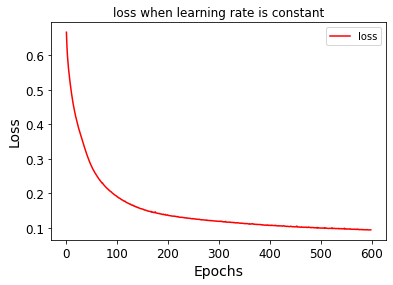

In [46]:
from sklearn.neural_network import MLPClassifier 

mlp_clf = MLPClassifier(random_state=42, max_iter=2000)
mlp_clf.fit(X_train, y_train)

y_pred = mlp_clf.predict(X_test)
print('best loss: ',mlp_clf.best_loss_)
print('accuracy: ',mlp_clf.score(X_test, y_test))

print('Max_iteration: ', mlp_clf.n_iter_)
print('Num of layers: ', mlp_clf.n_layers_)
print('Num of output layer: ', mlp_clf.n_outputs_)
drawGraphs(mlp_clf.n_iter_, mlp_clf.learning_rate, mlp_clf.loss_curve_, [])

Observation:

Using default values for all hyperparameters for the MLP, we can see that model is performing relatively good, observing the graph above we can see that we reached best loss 0.09 and accuracy 0.95.

In below cells, I will tune hyperparameters and see how it influnces prediction of the classifier

Let us first change hidden layers to 2 with 20 neurons in first hidden layer and 8 neaurons in the second hidden layer, let us also set the activation function to relu and see how that influences the loss

accuracy:  0.9703733766233766
best loss:  0.08594086074839075
Max_iteration:  395
Num of layers:  4
Num of output layer:  1


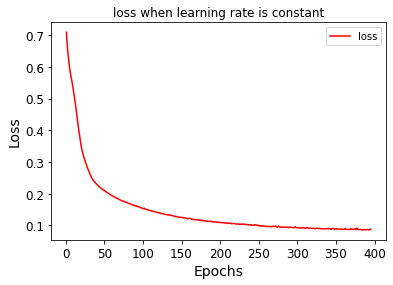

In [47]:
#activation='logistic', solver='adam', alpha=0.0001,learning_rate='constant', learning_rate_init=0.001
mlp_clf = MLPClassifier(max_iter=2000, random_state=42, hidden_layer_sizes=(20,8), activation='relu')
mlp_clf.fit(X_train, y_train)

y_pred = mlp_clf.predict(X_test)
print('accuracy: ',mlp_clf.score(X_test, y_test))
print('best loss: ',mlp_clf.best_loss_)
print('Max_iteration: ', mlp_clf.n_iter_)
print('Num of layers: ', mlp_clf.n_layers_)
print('Num of output layer: ', mlp_clf.n_outputs_)
drawGraphs(mlp_clf.n_iter_, mlp_clf.learning_rate, mlp_clf.loss_curve_, [])

Observations:

With just two hidden layer and changing activation function to relu, the loss improved and reached as low as 0.08, and optimal minima was found by iteration 395, it also produced accuracy of 0.97 which is good

Keeping in mind the two hidden layer structure with activation layer = relue, i will tune the learning rate and see how that influences the training the model, i will set learning rate to 0.01

accuracy:  0.9823457792207793
best loss:  0.04525249230321203
Max_iteration:  249
Num of layers:  4
Num of output layer:  1


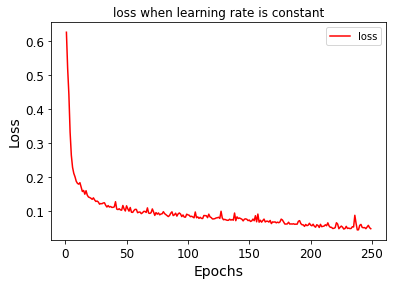

In [48]:
mlp_clf = MLPClassifier(max_iter=2000, random_state=42, hidden_layer_sizes=(20,8), 
                                activation='relu', learning_rate_init=0.01)
mlp_clf.fit(X_train, y_train)

y_pred = mlp_clf.predict(X_test)

print('accuracy: ',mlp_clf.score(X_test, y_test))
print('best loss: ',mlp_clf.best_loss_)
print('Max_iteration: ', mlp_clf.n_iter_)
print('Num of layers: ', mlp_clf.n_layers_)
print('Num of output layer: ', mlp_clf.n_outputs_)
drawGraphs(mlp_clf.n_iter_, mlp_clf.learning_rate, mlp_clf.loss_curve_, [])

Observations:

Keeping hidden layers two as previous step and changing just learning rate to 0.1 constant through all epochs and with accuracy of 0.98, i observe improvement in loss that produces best at 0.045, getting best optima at iteration 249

on this next cell, I will change validation threshold to 0.2 and also allow early stopping while configuring solver to be stochasic gradiant descent (sgd), I will also change lear_rate to adaptive and set learning_rate_intial to 0.01 and see how these will influence the MLP

best loss:  0.11983647750639556
accuracy:  0.966314935064935
Max_iteration:  49
loss:  0.11983647750639556
Num of layers:  4
Num of output layer:  1


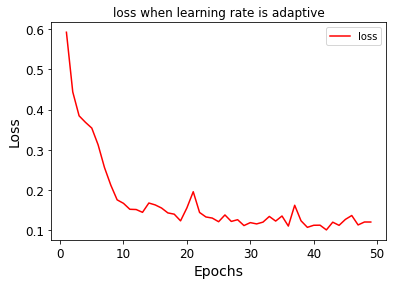

In [55]:
mlp_clf = MLPClassifier(max_iter=2000, random_state=42, hidden_layer_sizes=(20,8),
                                activation='relu', learning_rate='adaptive', learning_rate_init=0.1, validation_fraction=0.2,
                                early_stopping=True)
mlp_clf.fit(X_train, y_train)

y_pred = mlp_clf.predict(X_test)

print('best loss: ',mlp_clf.loss_)
print('accuracy: ',mlp_clf.score(X_test, y_test))
print('Max_iteration: ', mlp_clf.n_iter_)
print('loss: ', mlp_clf.loss_)
print('Num of layers: ', mlp_clf.n_layers_)
print('Num of output layer: ', mlp_clf.n_outputs_)
drawGraphs(mlp_clf.n_iter_, mlp_clf.learning_rate, mlp_clf.loss_curve_, [])

Observations:

With early stopping enabled, accuracy droped to 0.96 while loss stayed @0.11, from the  graph one can observe that minimal optima is not reached yet 

Lastly, we used relu as the activation through out previous experiments, we will try to change our best scenario and see how that influencies MLP

accuracy:  0.9717938311688312
best loss:  0.10207003953256927
Max_iteration:  250
Num of layers:  4
Num of output layer:  1


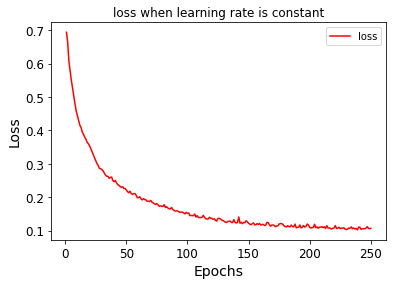

In [57]:
mlp_clf = MLPClassifier(max_iter=2000, random_state=42, hidden_layer_sizes=(20,8), 
                                activation='logistic', learning_rate_init=0.01)
mlp_clf.fit(X_train, y_train)

y_pred = mlp_clf.predict(X_test)

print('accuracy: ',mlp_clf.score(X_test, y_test))
print('best loss: ',mlp_clf.best_loss_)
print('Max_iteration: ', mlp_clf.n_iter_)
print('Num of layers: ', mlp_clf.n_layers_)
print('Num of output layer: ', mlp_clf.n_outputs_)
drawGraphs(mlp_clf.n_iter_, mlp_clf.learning_rate, mlp_clf.loss_curve_, [])

Observations:

From the result above we see that activation function has great influence on MLP, as loss increased to 0.10 from 0.04 when it was relu.

This can be explained in the fact that logistic calculation and its derivitives for back propogations takes longer than relu, simply relu is much faster and simpler hence it does better specially on hidden layers

# Coclusion:
1. MLP is doing much better on given dataset when compared to Linear classifiers with sometimes accuracy reaching more than 90%, so it genrelized well to test_data.
2. Hyperparameters such epochs, hidden_layers, activation functions, momentum and so on have greate influence on how well MLP will perform:
3. For just one hidden layer even with relu activation function mlp did not as good as when we increase the hidden layers.
4. I observed that Relu activation function doing much better than logistic and slightly better than tanh, this is because it is simpler and its derivitives is much simpler.



# Convolutional Neural Networks

I have financial dataset which detects frauds based on given scenarios, we have trained models from supervised learning to unsupervised learning, some suffering from overfiting, others from data density while some did perform well. That being the case, CNN is mostly used for image dataset which I did not choose for this profitlio.

That being said, there are aspiring researches being performed using CNN for fraud detection, some finding very good results even better than MLP or SVM or Random Forest and other supervised learning techniques.

I will not be doing CNN for this particular coursework, but for interesting ideas, you can see papers written using CNN for Fraud detection such as:
1. ConvNets for Fraud Detection analysis by Alae Chouiekha, EL Hassane IbnEL Hajb; link: https://doi.org/10.1016/j.procs.2018.01.107
2. Credit Card Fraud Detection Using Convolutional Neural Networks by Kang Fu, Dawei Cheng, Yi Tu, Liqing Zhang; link: https://link.springer.com/chapter/10.1007/978-3-319-46675-0_53
